Possible datasets
 - https://data.world/crowdflower/apple-twitter-sentiment
 - https://paperswithcode.com/dataset/stocknet-1
 - https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction
 - https://www.kaggle.com/datasets/thedevastator/tweet-sentiment-s-impact-on-stock-returns
 - https://ieee-dataport.org/open-access/stock-market-tweets-data
 - https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset
 - https://www.kaggle.com/datasets/kazanova/sentiment140
 - https://www.kaggle.com/datasets/sixlack/finaldf (using)
 - https://www.kaggle.com/datasets/utkarshxy/stock-markettweets-lexicon-data (using)
 - https://www.kaggle.com/datasets/sidarcidiacono/news-sentiment-analysis-for-stock-data-by-company/data (using)
 - https://ieee-dataport.org/open-access/stock-market-tweets-data (not good)
 - https://redu.unicamp.br/dataset.xhtml?persistentId=doi:10.25824/redu/GFJHFK (not good)

In [1]:
import os
import re
import time
import numpy as np
import pandas as pd
from collections import Counter
from multiprocessing import Pool
import multiprocessing

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim.models import Word2Vec
from torchtext.data import get_tokenizer
import torchtext
import fasttext

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
# import kaggle

import helper_data, helper_model

# nltk.download('stopwords')

c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Steven\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Steven\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# !pip install fasttext

## Loading:

In [3]:
# new_directory = "/content/sample_data/"
# os.chdir(new_directory)

In [4]:
RANDOM_STATE = 2023
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
SEQUENCE_LENGTH = 300
CURRENT_DIRECTORY = os.getcwd()
W2V_SIZE = 300
NUM_CORE = multiprocessing.cpu_count()
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10


In [5]:
# DATASETS = [
#     {
#         'name': "training.1600000.processed.noemoticon.csv",
#         'api': "kazanova/sentiment140",
#         'location': "data",
#         'url': "https://www.kaggle.com/datasets/kazanova/sentiment140"
#     },
#     {
#         'name': "reddit_wsb.csv",
#         'api': "gpreda/reddit-wallstreetsbets-posts",
#         'location': "data",
#         'url': "https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts"
#     },
#     {
#         'name': "stock_data.csv",
#         'api': "yash612/stockmarket-sentiment-dataset",
#         'location': "data",
#         'url': "https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset"
#     },
#     {
#         'name': "stock_tweets.csv",
#         'api': "equinxx/stock-tweets-for-sentiment-analysis-and-prediction",
#         'location': "data/unorganized/Stock Tweets for Sentiment Analysis and Prediction",
#         'url': "https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction"
#     },
#     {
#         'name': "Company_Tweet.csv",
#         'api': "omermetinn/tweets-about-the-top-companies-from-2015-to-2020",
#         'location': "data/unorganized/Tweets about the Top Companies from 2015 to 2020",
#         'url': "https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020"
#     },
#     {
#         'name': "stockerbot-export.csv",
#         'api': "davidwallach/financial-tweets",
#         'location': "data/unorganized/Financial Tweets",
#         'url': "https://www.kaggle.com/datasets/davidwallach/financial-tweets"
#     }
# ]

# for dataset_info in DATASETS:
#     dataset_name = dataset_info['name']
#     dataset_location = dataset_info['location']

#     if not os.path.exists(os.path.join(dataset_info['location'], dataset_name)):
#         print(f"Downloading {dataset_name} from {dataset_info['url']} to {dataset_location}...")
#         kaggle.api.dataset_download_files(dataset_info['api'], path=dataset_location, unzip=True)


In [6]:
dataset_filename = {
    '0': ("training.1600000.processed.noemoticon.csv", ["target", "ids", "date", "flag", "user", "text"]),
    '1': ("stock_data.csv", ["text", "target"]),
    '2': ("nasdaq.csv", ["Label", "Ticker", "Headline"]), # 0 negative, 1 positive, 2 neural
    '3': ("djia_news copy.csv", ["Label", "Ticker", "Headline"]), # 0 negative, 1 positive, 2 neural
    '4': ("data-3.csv", ["Sentence", "Sentiment"]),
    '5': ("sentiment.csv", ["Stock Ticker", "Tweet Text", "Sentiment", "Tweet URL"]),
    '6': ('train_tweet.csv', ["id", "label", "tweet"])  # 0 positive, 1 negative
}

In [7]:
dataset_path = os.path.join("", "data", dataset_filename["0"][0])
df0 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["0"][1])
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
df0.target = df0.target.apply(lambda x: decode_map[int(x)])
df0 = df0[['text', 'target']]

dataset_path = os.path.join("", "data", dataset_filename["1"][0])   # test dataset
df1 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["1"][1], skiprows=1)
df1.rename(columns={df1.columns[0]: 'text'}, inplace=True)
decode_map = {-1: "NEGATIVE", 1: "POSITIVE"}
df1.target = df1.target.apply(lambda x: decode_map[int(x)])
df_test = df1

dataset_path = os.path.join("", "data", dataset_filename["2"][0])
df2 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["2"][1], skiprows=1)
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 1: "POSITIVE"}
df2['target'] = df2['Label'].apply(lambda x: decode_map[int(x)])
df2 = df2[['Headline', 'target']]
df2.rename(columns={df2.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["3"][0])
df3 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["3"][1], skiprows=1)
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 1: "POSITIVE"}
df3['target'] = df3['Label'].apply(lambda x: decode_map[int(x)])
df3 = df3[['Headline', 'target']]
df3.rename(columns={df3.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["4"][0])
df4 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["4"][1], skiprows=1)
decode_map = {"negative": "NEGATIVE", "neutral": "NEUTRAL", "positive": "POSITIVE"}
df4['target'] = df4['Sentiment'].apply(lambda x: decode_map[x])
df4.drop(columns=['Sentiment'], inplace=True)
df4.rename(columns={df4.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["5"][0])
df5 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["5"][1], skiprows=1)
decode_map = {"Negative": "NEGATIVE", "Positive": "POSITIVE"}
df5['target'] = df5['Sentiment'].apply(lambda x: decode_map[x])
df5 = df5[['Tweet Text', 'target']]
df5.rename(columns={df5.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["6"][0])
df6 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["6"][1], skiprows=1)
decode_map = {0: "POSITIVE", 1: "NEGATIVE"}
df6['target'] = df6['label'].apply(lambda x: decode_map[int(x)])
df6 = df6[['tweet', 'target']]
df6.rename(columns={df6.columns[0]: 'text'}, inplace=True)

In [8]:
total_rows = len(df0) + len(df2) + len(df3) + len(df4) + len(df5) + len(df6)
print("Total number of rows:", total_rows)

Total number of rows: 1653866


In [9]:
df = pd.concat([df0, df2, df3, df4, df5, df6], ignore_index=True)
df.shape

(1653866, 2)

In [10]:
df = helper_data.shuffle_dataframe(df)

In [11]:
top_10 = df.head(2000)
last_10 = df.tail(2000) 
df = pd.concat([top_10, last_10])

In [12]:
df = df[df['target'] != "NEUTRAL"]

In [13]:
df[:-10]

,text,target
585981,Cherry sprite....still just...isn't right.,NEGATIVE
203260,@blakelytuten I love you girlll! Wish you were...,NEGATIVE
790866,does not feel good.,NEGATIVE
1448399,@kayla_wat Get 100 followers a day using www.t...,POSITIVE
1269140,captain procrastinator finallyy found her dres...,POSITIVE
...,...,...
1319604,@nickgerig @millsustwo nice seeing you again n...,POSITIVE
469649,why is @alertthingy not working?,NEGATIVE
1275931,@IAMTHEMATRIX the fountain of youth aint reall...,POSITIVE
1376931,buying seeds for my farm,POSITIVE


## Preprocessing:

In [14]:
%%time
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = [word for word in text.split() if word not in stop_words]
    if stem:
        tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))
df_test.text = df_test.text.apply(lambda x: preprocess(x))

CPU times: total: 62.5 ms
Wall time: 316 ms


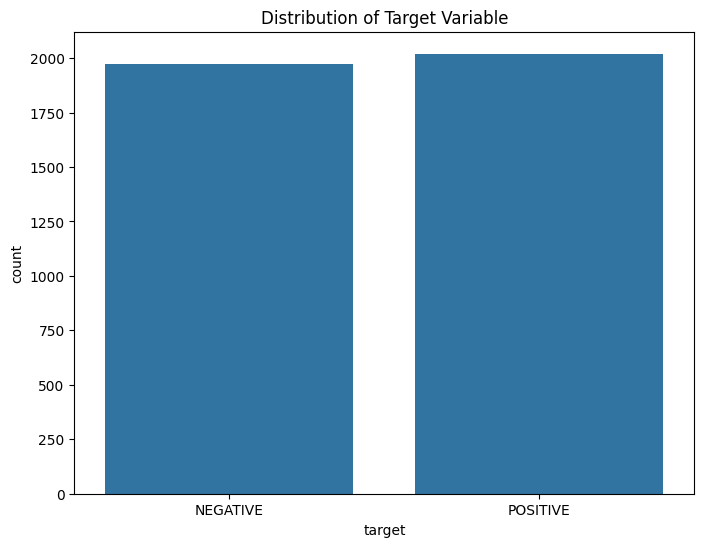

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='target')
plt.title('Distribution of Target Variable')
plt.show()

In [16]:
df_train, df_val= train_test_split(df, test_size=1-TRAIN_SIZE, random_state=RANDOM_STATE)

## Training Fasttext and Word2vec

https://www.analyticsvidhya.com/blog/2023/01/introduction-to-fasttext-embeddings-and-its-implication/

In [17]:
%%time
CURRENT_DIRECTORY = os.getcwd()
MODEL_PATH = os.path.join(CURRENT_DIRECTORY, "fasttext_model.bin")
TRAINING_DATA_PATH = os.path.join(CURRENT_DIRECTORY, "fasttext_train.txt")

if os.path.isfile(MODEL_PATH):
    fasttext_model = fasttext.load_model(MODEL_PATH)
else:
    sentences = [row.split() for row in df_train['text']]
    with open(TRAINING_DATA_PATH, "w") as f:
        for sentence in sentences:
            f.write(" ".join(sentence) + "\n")
    fasttext_model = fasttext.train_unsupervised(TRAINING_DATA_PATH, model='skipgram')
    fasttext_model.save_model(MODEL_PATH)


CPU times: total: 344 ms
Wall time: 780 ms


In [18]:
# %%time
# MODEL_PATH = os.path.join(CURRENT_DIRECTORY, "word2vec_model.model")

# if os.path.isfile(MODEL_PATH):
#     w2v_model = Word2Vec.load(MODEL_PATH)
# else:
#     sentences = [row.split() for row in df_train['text']]
#     w2v_model = Word2Vec(sentences, vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=NUM_CORE)
#     w2v_model.build_vocab(sentences)
#     w2v_model.train(sentences, total_examples=len(documents), epochs=W2V_EPOCH)
#     w2v_model.save(MODEL_PATH)

### Tokenization:

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_val = pad_sequences(tokenizer.texts_to_sequences(df_val.text), maxlen=SEQUENCE_LENGTH)
# x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

### Embedding Layer:

In [20]:
%%time
EMBEDDING_DIM = fasttext_model.get_dimension()
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_matrix[i] = fasttext_model.get_word_vector(word)

CPU times: total: 78.1 ms
Wall time: 102 ms


In [21]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist()).reshape(-1,1)
y_val = encoder.transform(df_val.target.tolist()).reshape(-1,1)
# y_test = encoder.transform(df_test.target.tolist()).reshape(-1,1)

## Preparation for PyTorch Model:

In [22]:
BATCH_SIZE = 128
NUM_EPOCHS = 3
LEARNING_RATE = 0.001

train_dataset = helper_model.TextDataset(x_train, y_train)
val_dataset = helper_model.TextDataset(x_val, y_val)
# test_dataset = helper_model.TextDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
directory_path = 'model'
helper_model.clean_directory(directory_path)

Deleted: model\rnn_bs128_epoch1.pt
Deleted: model\rnn_bs128_epoch2.pt
Deleted: model\rnn_bs128_epoch3.pt


In [24]:
helper_model.train(train_loader, val_loader, embedding_matrix, BATCH_SIZE, NUM_EPOCHS, LEARNING_RATE, save_path="model/")

Epoch 1/3: 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Epoch 1, Loss: 0.6779212236404419, Accuracy: 0.7247


Epoch 2/3: 100%|██████████| 25/25 [00:06<00:00,  4.00it/s]


Epoch 2, Loss: 0.5985510134696961, Accuracy: 0.7397


Epoch 3/3: 100%|██████████| 25/25 [00:20<00:00,  1.22it/s]


Epoch 3, Loss: 0.5495735359191894, Accuracy: 0.7584


In [25]:
model = helper_model.SentimentClassifier(embedding_matrix) 
model_path = 'model\\rnn_bs128_epoch3.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

## Evaluate

Evaluate on the validation set

Accuracy: 0.7584
F1-Score: 0.7516
ROC-AUC: 0.8309


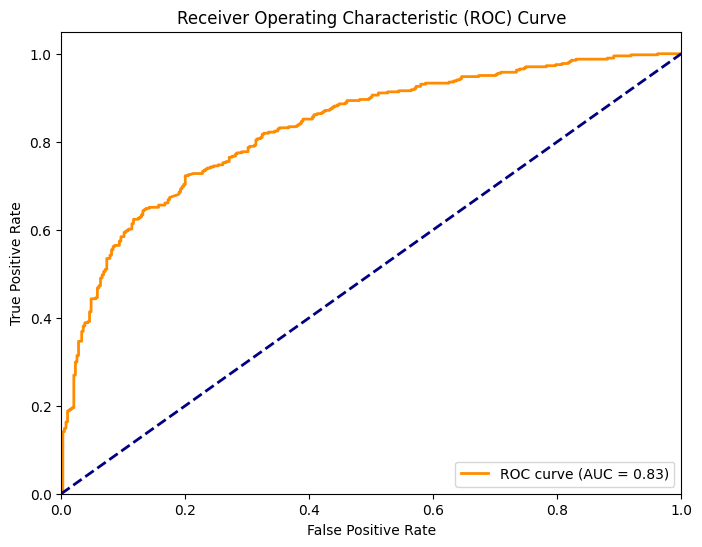

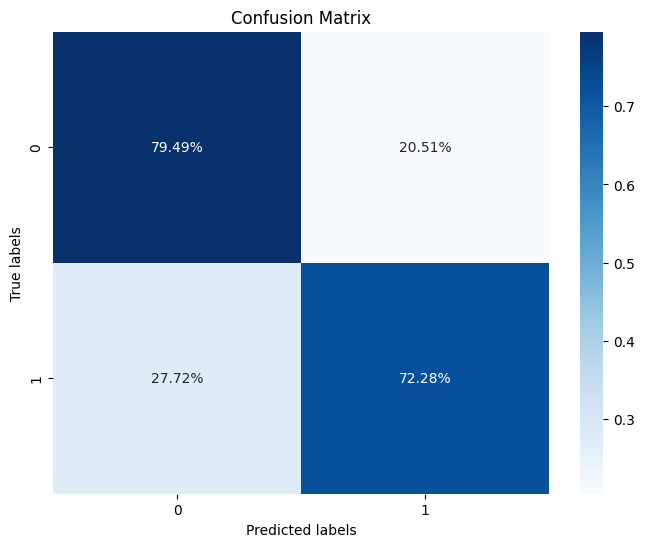

              precision    recall  f1-score   support

    NEGATIVE       0.74      0.79      0.76       395
    POSITIVE       0.78      0.72      0.75       404

    accuracy                           0.76       799
   macro avg       0.76      0.76      0.76       799
weighted avg       0.76      0.76      0.76       799



In [26]:
mislabeled_examples = helper_model.evaluate_model(model, val_loader, y_val, embedding_matrix, df_val["text"], threshold=0.5)

## Test

Evaluate on the testing set

In [33]:
dataset_path = os.path.join("", "data", dataset_filename["1"][0])
df1 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["1"][1], skiprows=1)
df1.rename(columns={df1.columns[0]: 'text'}, inplace=True)
# decode_map = {-1: "NEGATIVE", 1: "POSITIVE"}
# df1.target = df1.target.apply(lambda x: decode_map[int(x)])
df1.text = df1.text.apply(lambda x: preprocess(x))


x_test = pad_sequences(tokenizer.texts_to_sequences(df1['text']), maxlen=SEQUENCE_LENGTH)
test_dataset = helper_model.TextDataset(x_test, np.zeros_like(x_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
df1["target"] = df1["target"].map({-1: "NEGATIVE", 1: "POSITIVE"})
y_test = encoder.transform(df1['target'].tolist()).reshape(-1, 1)

Accuracy: 0.5070
F1-Score: 0.5470
ROC-AUC: 0.5350


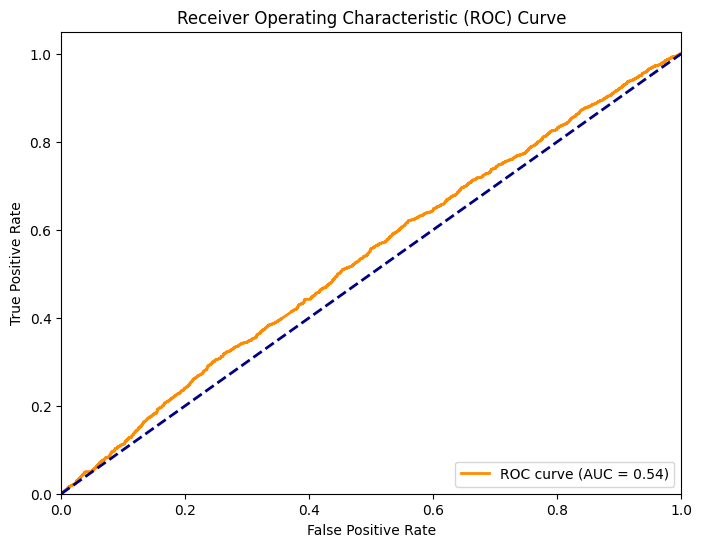

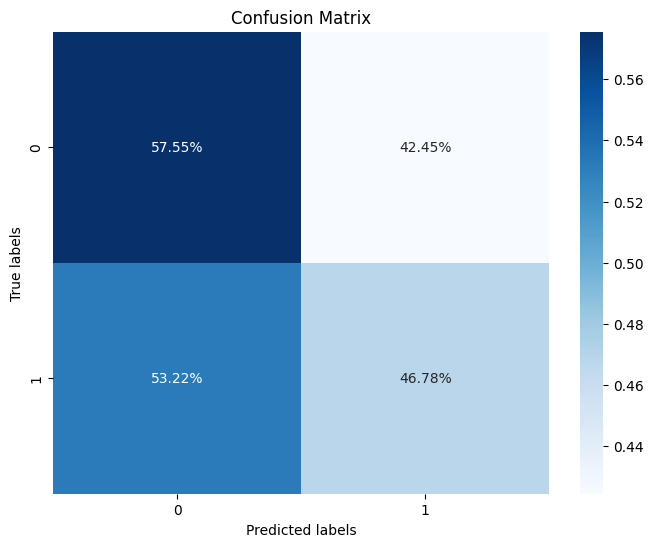

              precision    recall  f1-score   support

    NEGATIVE       0.38      0.58      0.46      2106
    POSITIVE       0.66      0.47      0.55      3685

    accuracy                           0.51      5791
   macro avg       0.52      0.52      0.50      5791
weighted avg       0.56      0.51      0.52      5791



In [34]:
res_stock = helper_model.evaluate_model(model, test_loader, y_test, embedding_matrix, df1["text"], threshold=0.5)

In [29]:
mislabels = res_stock
short_texts, texts_with_not, other_errors = helper_model.categorize_errors(mislabels)
helper_model.quantify_errors(short_texts, texts_with_not, other_errors)
helper_model.deep_dive(short_texts, texts_with_not)

Number of short texts: 356
Number of texts with 'not': 61
Number of other errors: 2438

Examples of short texts:
mnta 12 00
x swing still
red ready break
bac 11 97 trade
sk gave

Examples of texts with 'not':
new target aap notice shakeout reading 8 49 buy dot monday
user saying zagg another 23
anyone noticed hge volume today thing pushes 6 today might runner next week
remain convinced either apple stock aap another five years sold already middle ground
fio ioscale announced today open compute summit hyperscale spinning disk replacement another game changer


In [30]:
helper_model.print_mislabeled_examples(res_stock)

Example 1:
Original Text: kickers watchlist xide tit soq pnk cpw bpz aj trade method 1 method 2 see prev posts
Predicted Label: 0
True Label: 1


Example 2:
Original Text: user afraid short amzn looking like near monopoly ebooks infrastructure service
Predicted Label: 0
True Label: 1


Example 3:
Original Text: mnta 12 00
Predicted Label: 0
True Label: 1


Example 4:
Original Text: monday relative weakness nyx win tie tap ice int bmc aon c chk biib
Predicted Label: 1
True Label: 0


Example 5:
Original Text: goog ower trend line channel test volume support
Predicted Label: 0
True Label: 1


Example 6:
Original Text: aap watch tomorrow ong entry
Predicted Label: 0
True Label: 1


Example 7:
Original Text: assuming fcx opens tomorrow 34 25 trigger buy still much like setup
Predicted Label: 0
True Label: 1


Example 8:
Original Text: momentum coming back etfc broke ma200 resistance solid volume friday ong set
Predicted Label: 0
True Label: 1


Example 9:
Original Text: ha hitting 35 65 me